In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from time import perf_counter
import seaborn as sns
import glob
import matplotlib.cm as cm

from sklearn.metrics import classification_report
from sklearn import metrics

In [3]:
image_dir = Path('/content/drive/MyDrive/Dataset')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,/content/drive/MyDrive/Dataset/Loitta/IMG_2024...,Loitta
1,/content/drive/MyDrive/Dataset/Bhangon/IMG_202...,Bhangon
2,/content/drive/MyDrive/Dataset/Bhangon/IMG_202...,Bhangon


Visualization

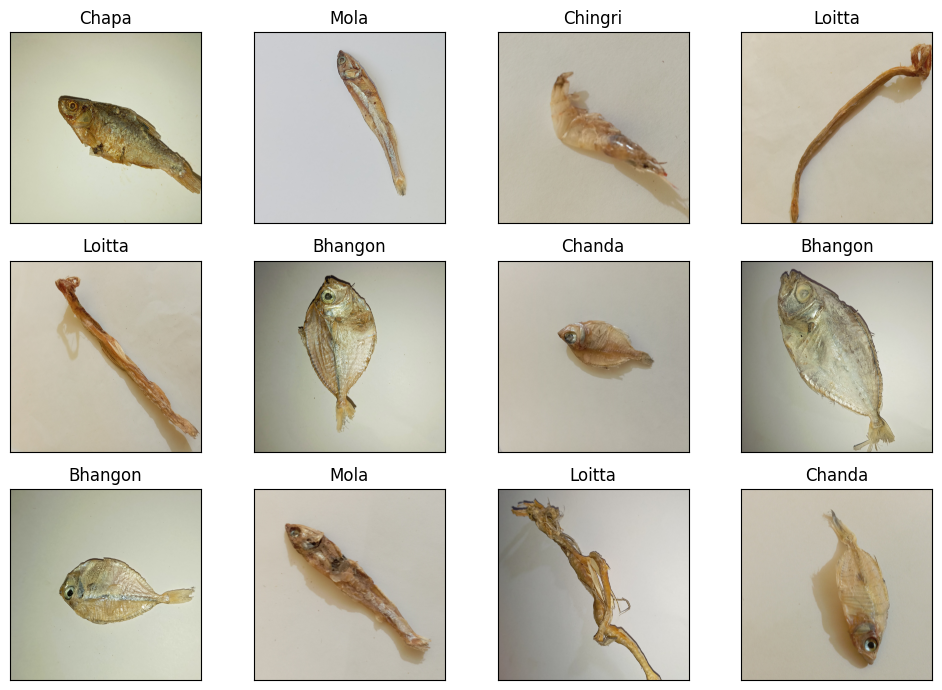

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [5]:
vc = image_df['Label'].value_counts()
print(vc)

Label
Loitta           450
Chapa            446
Bhangon          444
Chingri          440
Chanda           440
Mola             429
Baspata Sutki    396
Name: count, dtype: int64


<ipython-input-13-76e10246d3d0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p=sns.barplot(x = vc.index, y = vc, palette = "rocket")


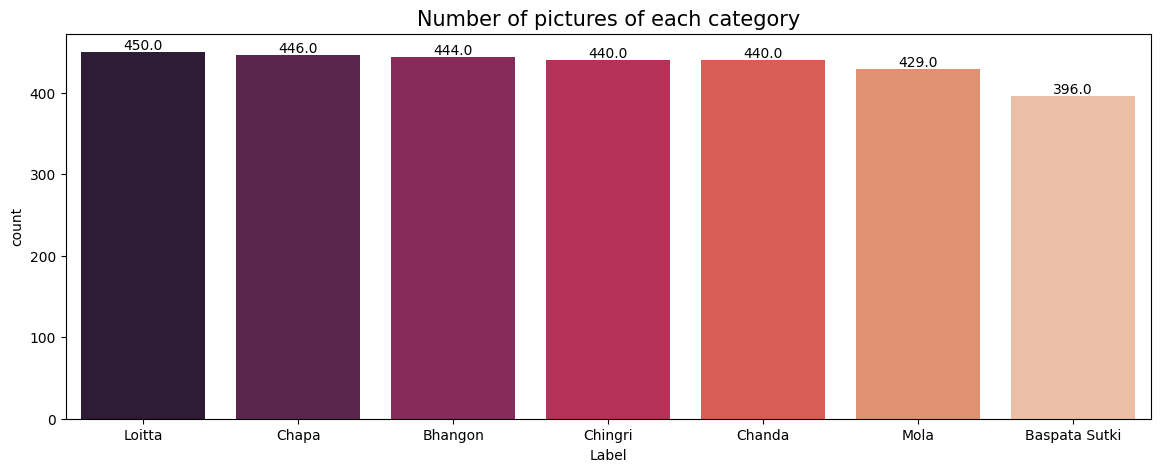

In [ ]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(14,5))
p=sns.barplot(x = vc.index, y = vc, palette = "rocket")

plt.title("Number of pictures of each category", fontsize = 15)

for i in p.containers:
    labels = [f'{v.get_height()}' for v in i]
    p.bar_label(i, labels=labels)

plt.show()

In [6]:
# train, validation = 80,80, test 20

def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [7]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [8]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()


Found 2436 validated image filenames belonging to 7 classes.
Found 2436 validated image filenames belonging to 7 classes.
Found 609 validated image filenames belonging to 7 classes.


## CNN 01

In [ ]:
input_shape = (32, 224, 224, 3)
n_classes = 7

model_01 = models.Sequential([
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax'),
])

model_01.build(input_shape=input_shape)
model_01.summary()

model_01.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (32, 220, 220, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (32, 110, 110, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (32, 108, 108, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (32, 106, 106, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 53, 53, 64)          0         
 g2D)                                                   

In [ ]:
history_01 = model_01.fit(train_images,validation_data=val_images,epochs=20,verbose=1)

Epoch 1/20
77/77 [==============================] - 1099s 14s/step - loss: 0.9354 - accuracy: 0.6552 - val_loss: 1.2215 - val_accuracy: 0.5222
Epoch 2/20
77/77 [==============================] - 266s 3s/step - loss: 0.5360 - accuracy: 0.8165 - val_loss: 0.4274 - val_accuracy: 0.8781
Epoch 3/20
77/77 [==============================] - 273s 4s/step - loss: 0.3320 - accuracy: 0.8859 - val_loss: 0.4635 - val_accuracy: 0.8461
Epoch 4/20
77/77 [==============================] - 271s 4s/step - loss: 0.2116 - accuracy: 0.9323 - val_loss: 0.2806 - val_accuracy: 0.9060
Epoch 5/20
77/77 [==============================] - 265s 3s/step - loss: 0.1609 - accuracy: 0.9487 - val_loss: 0.1921 - val_accuracy: 0.9269
Epoch 6/20
77/77 [==============================] - 266s 3s/step - loss: 0.1404 - accuracy: 0.9544 - val_loss: 0.1388 - val_accuracy: 0.9446
Epoch 7/20
77/77 [==============================] - 267s 3s/step - loss: 0.0984 - accuracy: 0.9696 - val_loss: 0.2465 - val_accuracy: 0.9134
Epoch 8/20




Train Accuracy and Loss Plot: 



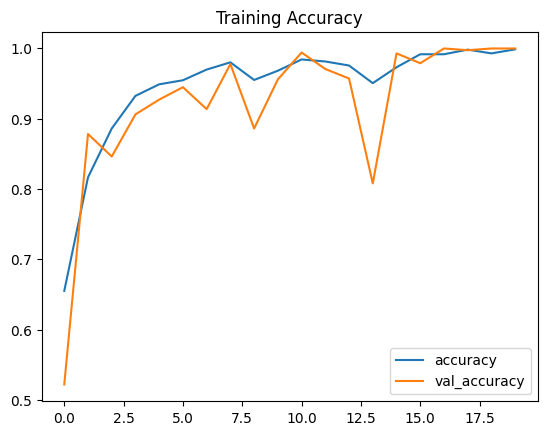

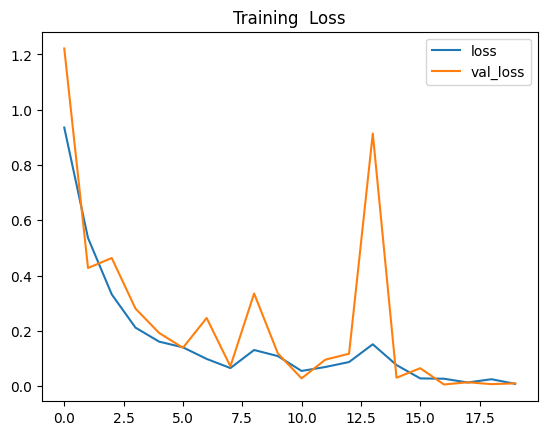



Accuracy on the test set: 94.25%
20/20 [==============================] - 33s 2s/step
Accuracy: 0.94253
Precision: 0.94383
Recall: 0.94253
F1 Score: 0.94257
               precision    recall  f1-score   support

Baspata Sutki       0.93      0.96      0.94        79
      Bhangon       0.94      0.99      0.96        83
       Chanda       0.87      0.93      0.90        80
        Chapa       0.98      0.99      0.99       100
      Chingri       0.92      0.92      0.92        84
       Loitta       0.99      0.92      0.96        93
         Mola       0.96      0.89      0.92        90

     accuracy                           0.94       609
    macro avg       0.94      0.94      0.94       609
 weighted avg       0.94      0.94      0.94       609

Confusion Matrix of CNN: 




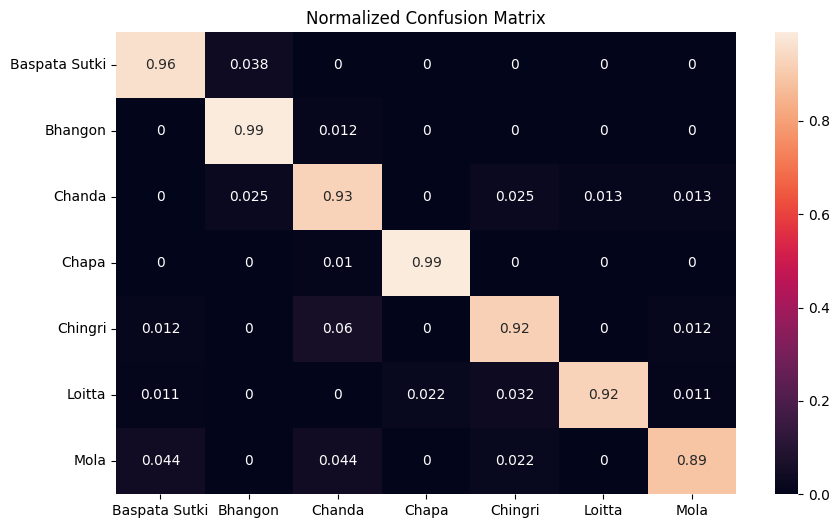

Performance: 

Rec=    94.21805517194096
Spe=    99.99049022232228
Pre=    94.32202507281471
FPR=    0.009509777677728705
FNR=    5.781944828059053
NPV=    99.9904905246041
FDR=    5.677974927185286




In [ ]:
print('\n')


val_acc = history_01.history['val_accuracy']
train_acc = history_01.history['accuracy']

results = model_01.evaluate(test_images, verbose=0)
res=results[1]
test_acc = [round(res,4)]
#ploting training acc loss
print("Train Accuracy and Loss Plot: \n")
pd.DataFrame(history_01.history)[['accuracy','val_accuracy']].plot()
plt.title("Training Accuracy")
plt.show()
pd.DataFrame(history_01.history)[['loss','val_loss']].plot()
plt.title("Training  Loss")
plt.show()
print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))

from sklearn.metrics import confusion_matrix
import seaborn as sns
pred = model_01.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = list(test_df.Label)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print(classification_report(y_test, pred))

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from numpy import mean
print("Confusion Matrix of CNN: \n\n")
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()
confusion_matrix=cf_matrix
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = len(y_test) - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
print("Performance: \n")
print("Rec=   ",mean(TPR)*100)
print("Spe=   ",mean(TNR)*100)
print("Pre=   ",mean(PPV)*100)
print("FPR=   ",mean(FPR)*100)
print("FNR=   ",mean(FNR)*100)
print("NPV=   ",mean(NPV)*100)
print("FDR=   ",mean(FDR)*100)
print("\n")

# CNN 2


In [9]:
input_shape = (32, 224, 224, 3)
n_classes = 7

model_02 = models.Sequential([
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_02.build(input_shape=input_shape)
model_02.summary()

model_02.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (32, 220, 220, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (32, 110, 110, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (32, 108, 108, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (32, 106, 106, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 53, 53, 64)          0         
 g2D)                                                   

In [10]:
history_02 = model_02.fit(train_images,validation_data=val_images,epochs=15,verbose=1)

Epoch 1/15
77/77 [==============================] - 1200s 15s/step - loss: 1.1562 - accuracy: 0.5694 - val_loss: 0.6132 - val_accuracy: 0.7869
Epoch 2/15
77/77 [==============================] - 284s 4s/step - loss: 0.4867 - accuracy: 0.8399 - val_loss: 0.2920 - val_accuracy: 0.8912
Epoch 3/15
77/77 [==============================] - 266s 3s/step - loss: 0.2767 - accuracy: 0.9076 - val_loss: 0.2164 - val_accuracy: 0.9245
Epoch 4/15
77/77 [==============================] - 270s 4s/step - loss: 0.1684 - accuracy: 0.9397 - val_loss: 0.0873 - val_accuracy: 0.9729
Epoch 5/15
77/77 [==============================] - 268s 3s/step - loss: 0.0963 - accuracy: 0.9651 - val_loss: 0.0654 - val_accuracy: 0.9762
Epoch 6/15
77/77 [==============================] - 270s 4s/step - loss: 0.0804 - accuracy: 0.9774 - val_loss: 0.0321 - val_accuracy: 0.9906
Epoch 7/15
77/77 [==============================] - 274s 4s/step - loss: 0.0723 - accuracy: 0.9766 - val_loss: 0.0288 - val_accuracy: 0.9893
Epoch 8/15




Train Accuracy and Loss Plot: 



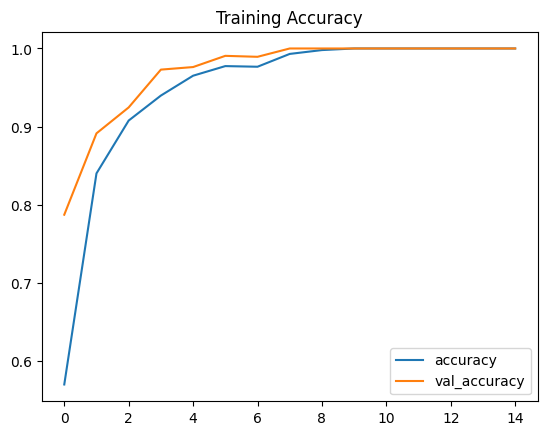

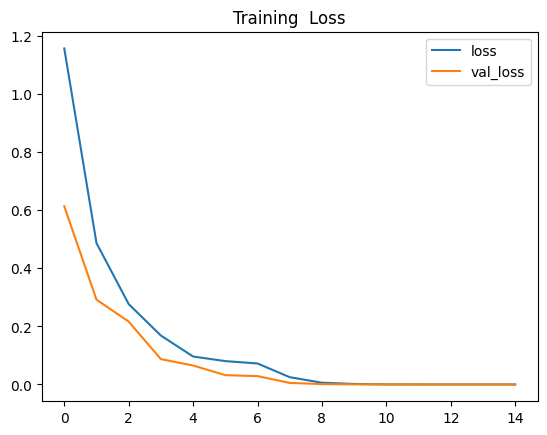



Accuracy on the test set: 94.25%
20/20 [==============================] - 34s 2s/step
Accuracy: 0.94253
Precision: 0.9433
Recall: 0.94253
F1 Score: 0.9427
               precision    recall  f1-score   support

Baspata Sutki       0.96      0.93      0.95        84
      Bhangon       0.93      0.96      0.94        79
       Chanda       0.87      0.91      0.89        87
        Chapa       0.99      0.99      0.99        79
      Chingri       0.95      0.95      0.95        93
       Loitta       0.95      0.95      0.95        85
         Mola       0.96      0.92      0.94       102

     accuracy                           0.94       609
    macro avg       0.94      0.94      0.94       609
 weighted avg       0.94      0.94      0.94       609

Confusion Matrix of CNN: 




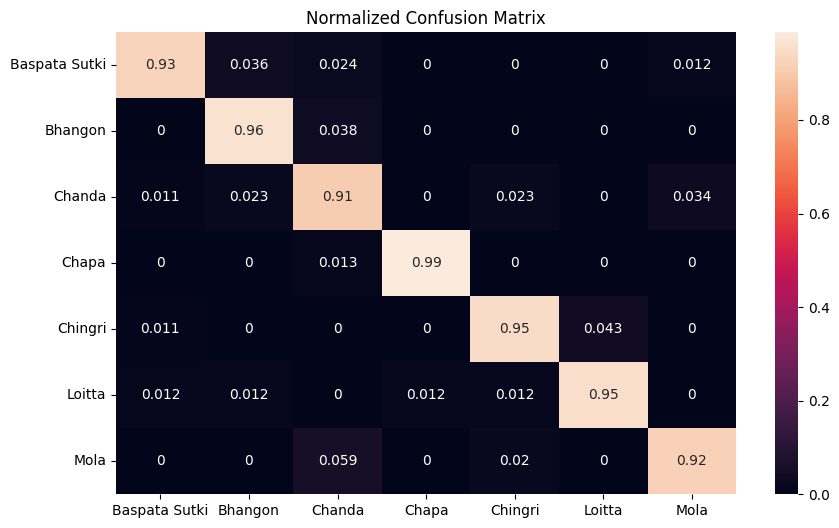

Performance: 

Rec=    94.38186938931246
Spe=    99.99075965360083
Pre=    94.44607071932872
FPR=    0.00924034639915715
FNR=    5.61813061068755
NPV=    99.99075966605358
FDR=    5.553929280671264




In [11]:
print('\n')


val_acc = history_02.history['val_accuracy']
train_acc = history_02.history['accuracy']

results = model_02.evaluate(test_images, verbose=0)
res=results[1]
test_acc = [round(res,4)]
#ploting training acc loss
print("Train Accuracy and Loss Plot: \n")
pd.DataFrame(history_02.history)[['accuracy','val_accuracy']].plot()
plt.title("Training Accuracy")
plt.show()
pd.DataFrame(history_02.history)[['loss','val_loss']].plot()
plt.title("Training  Loss")
plt.show()
print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))

from sklearn.metrics import confusion_matrix
import seaborn as sns
pred = model_02.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = list(test_df.Label)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print(classification_report(y_test, pred))

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from numpy import mean
print("Confusion Matrix of CNN: \n\n")
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()
confusion_matrix=cf_matrix
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = len(y_test) - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
print("Performance: \n")
print("Rec=   ",mean(TPR)*100)
print("Spe=   ",mean(TNR)*100)
print("Pre=   ",mean(PPV)*100)
print("FPR=   ",mean(FPR)*100)
print("FNR=   ",mean(FNR)*100)
print("NPV=   ",mean(NPV)*100)
print("FDR=   ",mean(FDR)*100)
print("\n")

# Transfer Learning Models

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

Found 2436 validated image filenames belonging to 7 classes.
Found 2436 validated image filenames belonging to 7 classes.
Found 609 validated image filenames belonging to 7 classes.






74836368/74836368 [==============================] - 0s 0us/step
DenseNet201 Model Training Started ===>>>
Epoch 1/10
77/77 [==============================] - 1098s 14s/step - loss: 0.2422 - accuracy: 0.9245 - val_loss: 0.0542 - val_accuracy: 0.9815
Epoch 2/10
77/77 [==============================] - 267s 3s/step - loss: 0.0167 - accuracy: 0.9955 - val_loss: 0.0118 - val_accuracy: 0.9971
Epoch 3/10
77/77 [==============================] - 261s 3s/step - loss: 0.0481 - accuracy: 0.9844 - val_loss: 0.0065 - val_accuracy: 0.9988
Epoch 4/10
77/77 [==============================] - 265s 3s/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/10
77/77 [==============================] - 268s 3s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.7163e-04 - val_accuracy: 1

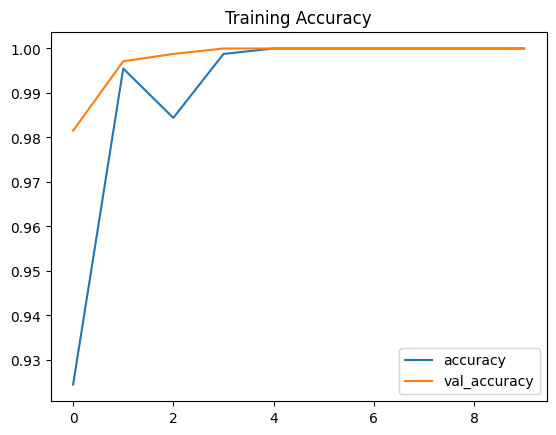

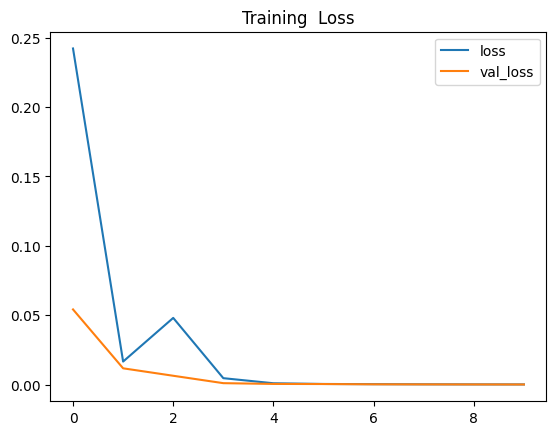



Accuracy on the test set: 99.67%
20/20 [==============================] - 36s 2s/step
Accuracy: 0.99672
Precision: 0.99679
Recall: 0.99672
F1 Score: 0.99672
               precision    recall  f1-score   support

Baspata Sutki       1.00      1.00      1.00        81
      Bhangon       1.00      0.99      0.99        88
       Chanda       0.98      1.00      0.99        88
        Chapa       1.00      1.00      1.00        97
      Chingri       1.00      1.00      1.00        76
       Loitta       1.00      1.00      1.00       101
         Mola       1.00      0.99      0.99        78

     accuracy                           1.00       609
    macro avg       1.00      1.00      1.00       609
 weighted avg       1.00      1.00      1.00       609

DenseNet201 Confusion Matrix: 




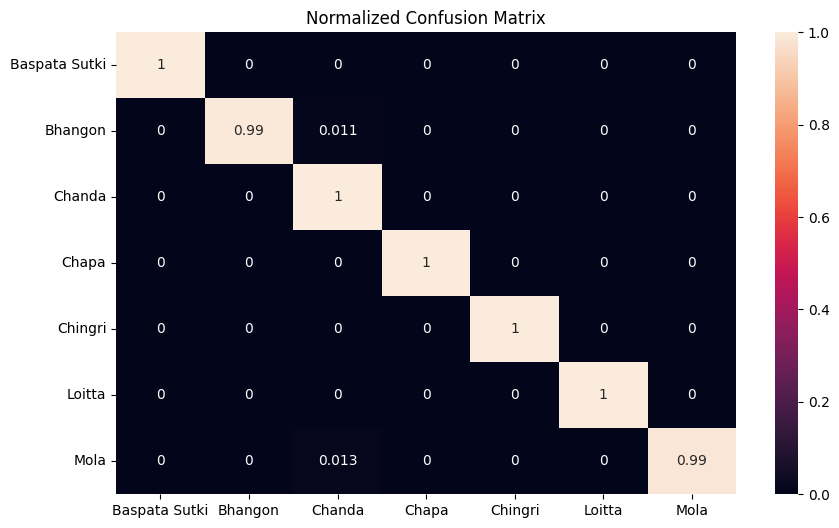

Performance: 

Rec=    99.65451215451215
Spe=    99.99943176341203
Pre=    99.66267018898598
FPR=    0.0005682365879734314
FNR=    0.34548784548784467
NPV=    99.99943177475407
FDR=    0.3373298110140223




80134624/80134624 [==============================] - 0s 0us/step
VGG19 Model Training Started ===>>>
Epoch 1/10
77/77 [==============================] - 272s 3s/step - loss: 1.1967 - accuracy: 0.6207 - val_loss: 0.4864 - val_accuracy: 0.8949
Epoch 2/10
77/77 [==============================] - 272s 4s/step - loss: 0.3242 - accuracy: 0.9126 - val_loss: 0.2310 - val_accuracy: 0.9380
Epoch 3/10
77/77 [==============================] - 268s 4s/step - loss: 0.1868 - accuracy: 0.9479 - val_loss: 0.1410 - val_accuracy: 0.9602
Epoch 4/10
77/77 [==============================] - 272s 4s/step - loss: 0.1332 - accuracy: 0.9561 - val_loss: 0.1081 - val_accuracy: 0.9672
Epoch 5/10
77/77 [==============================] - 277s 4s/step - loss: 0.1044 - accuracy: 0.9721 - val_loss: 0.0834 - val_acc

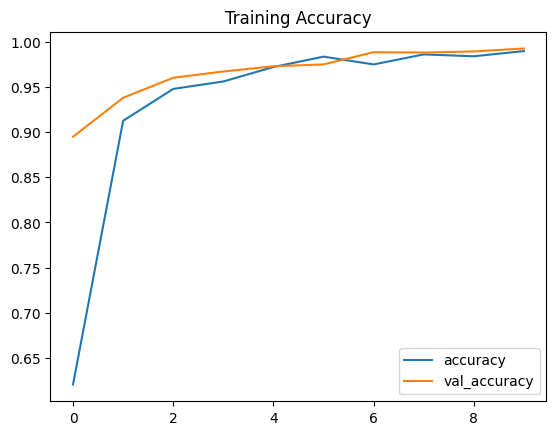

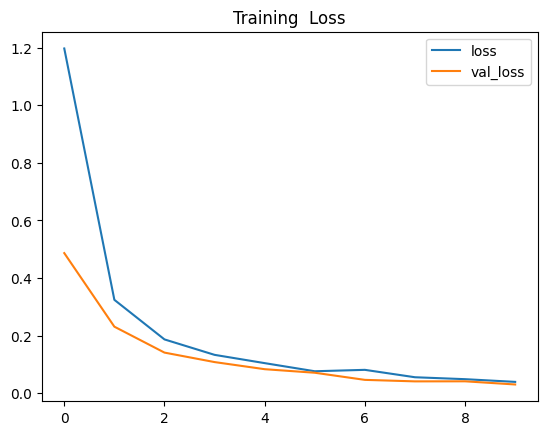



Accuracy on the test set: 97.87%
20/20 [==============================] - 33s 2s/step
Accuracy: 0.97865
Precision: 0.97989
Recall: 0.97865
F1 Score: 0.97884
               precision    recall  f1-score   support

Baspata Sutki       0.96      0.99      0.98        81
      Bhangon       1.00      0.99      0.99        88
       Chanda       1.00      0.97      0.98        88
        Chapa       1.00      0.98      0.99        97
      Chingri       0.90      1.00      0.95        76
       Loitta       1.00      0.99      1.00       101
         Mola       0.97      0.94      0.95        78

     accuracy                           0.98       609
    macro avg       0.98      0.98      0.98       609
 weighted avg       0.98      0.98      0.98       609

VGG19 Confusion Matrix: 




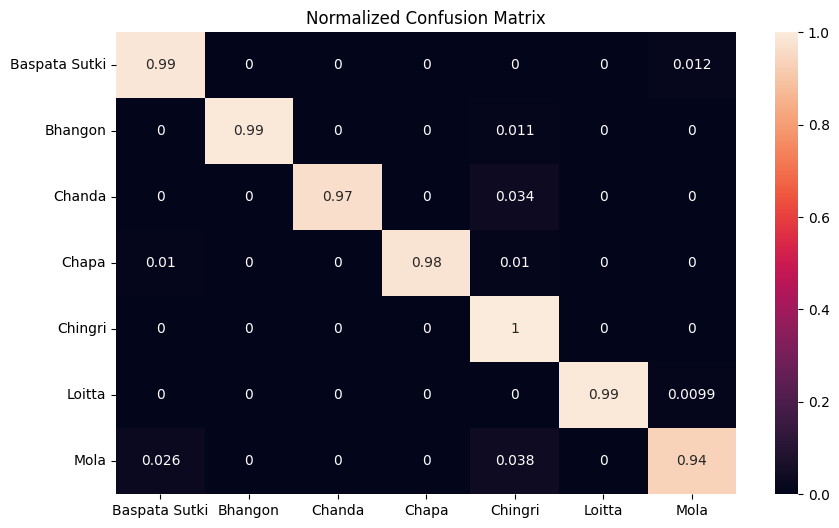

Performance: 

Rec=    97.82253806615006
Spe=    99.99641864813512
Pre=    97.93641061829015
FPR=    0.003581351864884772
FNR=    2.177461933849943
NPV=    99.99641881067083
FDR=    2.063589381709854




In [ ]:
# Dictionary with the models

models = {
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
print('\n')

# Fit the models
for name, model in models.items():
    print('\n')

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m


    print(f"{name:2} Model Training Started ===>>>")


    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=10,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:2} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

    results = m.evaluate(test_images, verbose=0)
    res=results[1]
    models[name]['test_accuracy'] = [round(res,4)]

    #ploting training acc loss
    print(f"{name:2} Train Accuracy and Loss Plot: \n")

    pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
    plt.title("Training Accuracy")
    plt.show()
    pd.DataFrame(history.history)[['loss','val_loss']].plot()
    plt.title("Training  Loss")
    plt.show()

    print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    pred = m.predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = list(test_df.Label)

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
    print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
    print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
    print(classification_report(y_test, pred))


    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    import math
    from numpy import mean


    print(f"{name:2} Confusion Matrix: \n\n")
    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize = (10,6))
    sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
    plt.title('Normalized Confusion Matrix')
    plt.show()

    confusion_matrix=cf_matrix

    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = len(y_test) - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    print("Performance: \n")
    print("Rec=   ",mean(TPR)*100)
    print("Spe=   ",mean(TNR)*100)
    print("Pre=   ",mean(PPV)*100)
    print("FPR=   ",mean(FPR)*100)
    print("FNR=   ",mean(FNR)*100)
    print("NPV=   ",mean(NPV)*100)
    print("FDR=   ",mean(FDR)*100)
    print("\n")

Found 2436 validated image filenames belonging to 7 classes.
Found 2436 validated image filenames belonging to 7 classes.
Found 609 validated image filenames belonging to 7 classes.






9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2 Model Training Started ===>>>
Epoch 1/10
77/77 [==============================] - 271s 3s/step - loss: 0.2274 - accuracy: 0.9228 - val_loss: 0.0428 - val_accuracy: 0.9885
Epoch 2/10
77/77 [==============================] - 264s 3s/step - loss: 0.0491 - accuracy: 0.9852 - val_loss: 0.0299 - val_accuracy: 0.9881
Epoch 3/10
77/77 [==============================] - 260s 3s/step - loss: 0.0191 - accuracy: 0.9934 - val_loss: 0.0035 - val_accuracy: 0.9992
Epoch 4/10
77/77 [==============================] - 265s 3s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 5/10
77/77 [==============================] - 259s 3s/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 9.1888e-04 - val_accuracy: 0.999

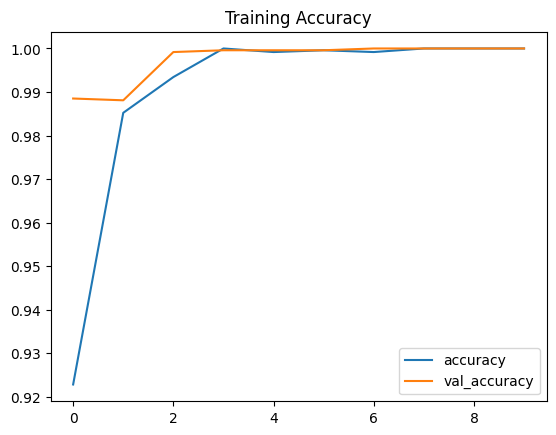

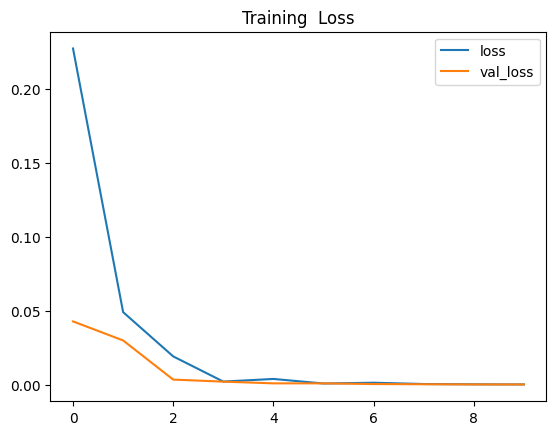



Accuracy on the test set: 99.51%
20/20 [==============================] - 33s 2s/step
Accuracy: 0.99507
Precision: 0.99511
Recall: 0.99507
F1 Score: 0.99507
               precision    recall  f1-score   support

Baspata Sutki       1.00      1.00      1.00        81
      Bhangon       0.99      1.00      0.99        88
       Chanda       0.99      1.00      0.99        88
        Chapa       1.00      1.00      1.00        97
      Chingri       1.00      0.99      0.99        76
       Loitta       1.00      0.99      1.00       101
         Mola       0.99      0.99      0.99        78

     accuracy                           1.00       609
    macro avg       0.99      0.99      0.99       609
 weighted avg       1.00      1.00      1.00       609

MobileNetV2 Confusion Matrix: 




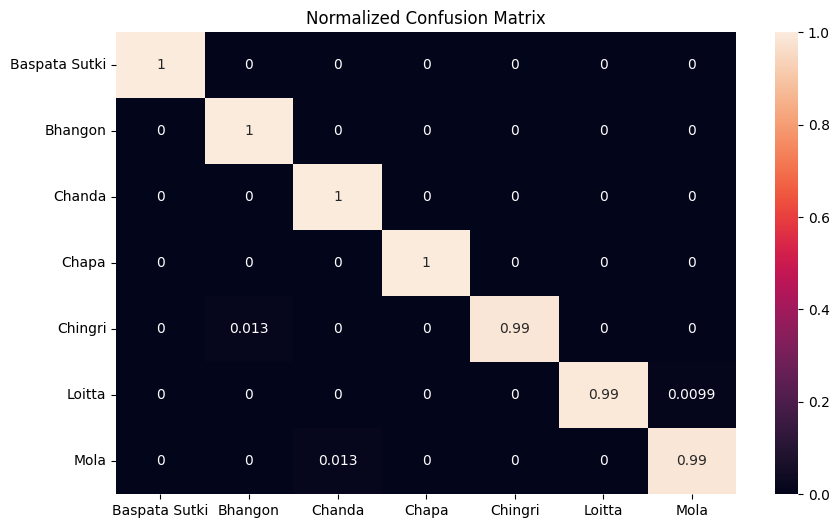

Performance: 

Rec=    99.48743717633765
Spe=    99.99915696904002
Pre=    99.49178254658575
FPR=    0.0008430309599709756
FNR=    0.5125628236623547
NPV=    99.9991569809653
FDR=    0.5082174534142433




87910968/87910968 [==============================] - 0s 0us/step
InceptionV3 Model Training Started ===>>>
Epoch 1/10
77/77 [==============================] - 276s 3s/step - loss: 0.4505 - accuracy: 0.8391 - val_loss: 0.0714 - val_accuracy: 0.9807
Epoch 2/10
77/77 [==============================] - 258s 3s/step - loss: 0.0784 - accuracy: 0.9758 - val_loss: 0.0928 - val_accuracy: 0.9680
Epoch 3/10
77/77 [==============================] - 256s 3s/step - loss: 0.0289 - accuracy: 0.9938 - val_loss: 0.0129 - val_accuracy: 0.9979
Epoch 4/10
77/77 [==============================] - 262s 3s/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 5/10
77/77 [==============================] - 257s 3s/step - loss: 0.0195 - accuracy: 0.9947 - val_loss: 0.0149 - val

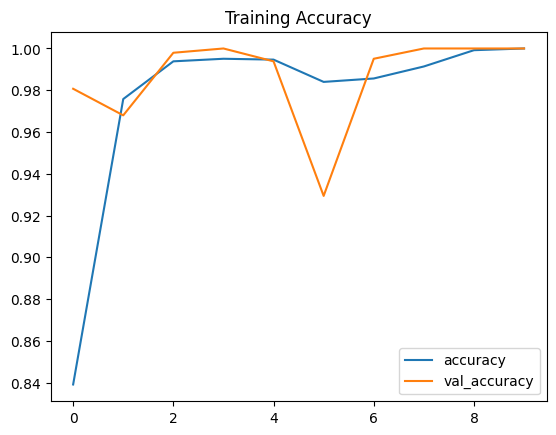

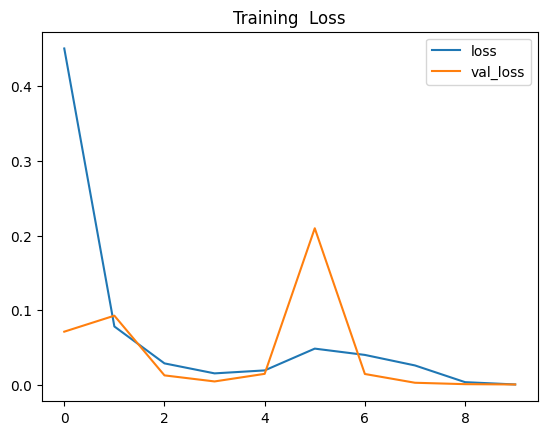



Accuracy on the test set: 98.85%
20/20 [==============================] - 35s 2s/step
Accuracy: 0.98851
Precision: 0.98881
Recall: 0.98851
F1 Score: 0.98849
               precision    recall  f1-score   support

Baspata Sutki       0.98      1.00      0.99        81
      Bhangon       1.00      0.97      0.98        88
       Chanda       0.97      1.00      0.98        88
        Chapa       1.00      0.99      0.99        97
      Chingri       1.00      1.00      1.00        76
       Loitta       0.98      1.00      0.99       101
         Mola       1.00      0.96      0.98        78

     accuracy                           0.99       609
    macro avg       0.99      0.99      0.99       609
 weighted avg       0.99      0.99      0.99       609

InceptionV3 Confusion Matrix: 




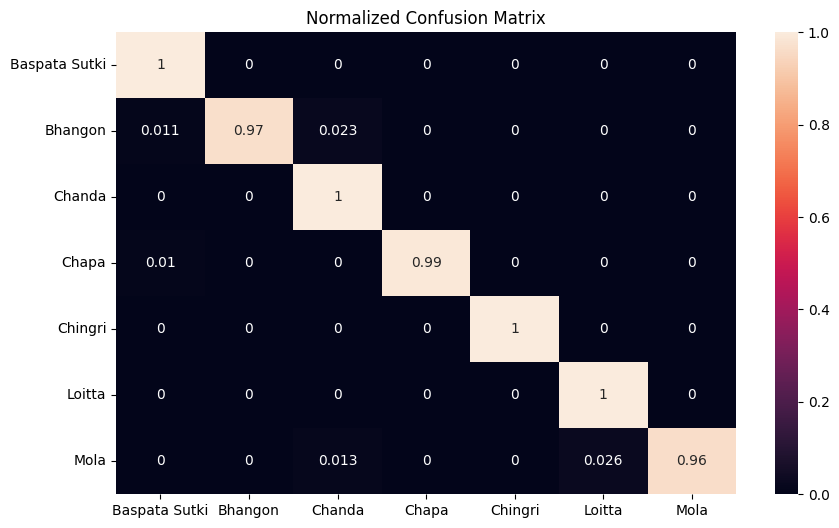

Performance: 

Rec=    98.8162610585291
Spe=    99.99805306095153
Pre=    98.8494188297532
FPR=    0.0019469390484718734
FNR=    1.183738941470899
NPV=    99.99805316713292
FDR=    1.1505811702467967




In [ ]:

# Dictionary with the models

models = {
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
print('\n')

# Fit the models
for name, model in models.items():
    print('\n')

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m


    print(f"{name:2} Model Training Started ===>>>")


    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=10,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:2} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

    results = m.evaluate(test_images, verbose=0)
    res=results[1]
    models[name]['test_accuracy'] = [round(res,4)]

    #ploting training acc loss
    print(f"{name:2} Train Accuracy and Loss Plot: \n")

    pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
    plt.title("Training Accuracy")
    plt.show()
    pd.DataFrame(history.history)[['loss','val_loss']].plot()
    plt.title("Training  Loss")
    plt.show()

    print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    pred = m.predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = list(test_df.Label)

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
    print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
    print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
    print(classification_report(y_test, pred))


    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    import math
    from numpy import mean


    print(f"{name:2} Confusion Matrix: \n\n")
    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize = (10,6))
    sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
    plt.title('Normalized Confusion Matrix')
    plt.show()

    confusion_matrix=cf_matrix

    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = len(y_test) - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    print("Performance: \n")
    print("Rec=   ",mean(TPR)*100)
    print("Spe=   ",mean(TNR)*100)
    print("Pre=   ",mean(PPV)*100)
    print("FPR=   ",mean(FPR)*100)
    print("FNR=   ",mean(FNR)*100)
    print("NPV=   ",mean(NPV)*100)
    print("FDR=   ",mean(FDR)*100)
    print("\n")

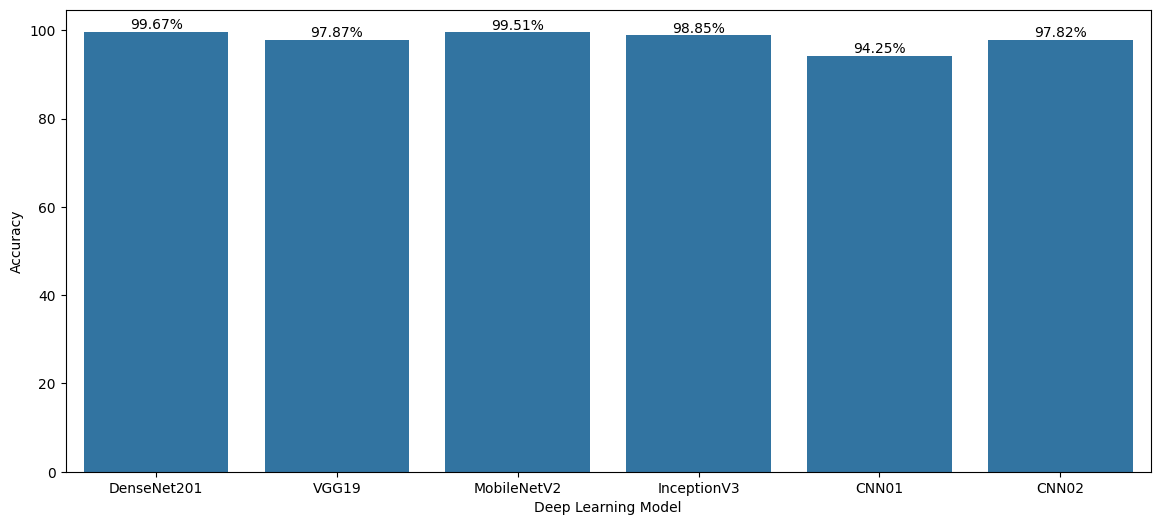

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data=
{'Deep Learning Model':['DenseNet201', 'VGG19', 'MobileNetV2', 'InceptionV3', 'CNN01', 'CNN02'],
'Accuracy':[99.67, 97.87, 99.51, 98.85, 94.25, 97.82]})

plt.figure(figsize=(14,6))

p = sns.barplot(x='Deep Learning Model', y='Accuracy',data=df)
for i in p.containers:
    labels = [f'{v.get_height():0.02f}%' for v in i]
    p.bar_label(i, labels=labels)